In [1]:
import numpy as np
import yaml
import matplotlib.pyplot as plt
import healpy as hp
import heracles
import heracles.dices as dices
from heracles.io import read

# SpaceBorne Vs DICES

In [2]:
config_path = "scripts/dices_config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
n = config['nsims']
nside = config['nside']
lmax = config['lmax']
mode = config['mode']  # "lognormal" or "gaussian"
Njk = config['Njk']
apply_mask = config['apply_mask']
binned = config['binned']
nbins = 3

print(f"Running DICES for {mode} simulations with nside={nside}, lmax={lmax}, n={n}, Njk={Njk}, apply_mask={apply_mask}, binned={binned}")

save = True
output_path = f"{mode}_dices/"
if apply_mask:
    output_path = "./masked_"+output_path
else:
    output_path = "./"+output_path

nlbins = 10
ls = np.arange(lmax+1)
ledges = np.logspace(np.log10(10), np.log10(lmax), nlbins + 1)
lgrid = (ledges[1:] + ledges[:-1]) / 2

if binned:
    ls = lgrid
    lmax = nlbins - 1

Running DICES for lognormal simulations with nside=256, lmax=256, n=100, Njk=30, apply_mask=True, binned=True


## Comparison

In [3]:
theory_cls = heracles.read(f"{mode}_sims/{mode}_sim_1/theory_cls.fits")
if binned:
    for key in list(theory_cls.keys()):
        theory_cls[key] = heracles.binned(theory_cls[key], ledges)

fl = -np.sqrt((ls+2)*(ls+1)*ls*(ls-1))
fl /= np.clip(ls*(ls+1), 1, None)

print(theory_cls["W1xW1"].shape)
_theory_cls = {}
_theory_cls[("POS", "POS", 1, 1)] = theory_cls["W1xW1"]
_theory_cls[("POS", "POS", 1, 2)] = theory_cls["W1xW2"]
_theory_cls[("POS", "POS", 2, 2)] = theory_cls["W2xW2"]

c = np.zeros((2, 2, lmax+1))
c[0, 0, :] = theory_cls["W3xW3"].array* fl**2
_theory_cls[("SHE", "SHE", 1, 1)] = heracles.Result(c)

c = np.zeros((2, 2, lmax+1))
c[0, 0, :] = theory_cls["W3xW4"].array* fl**2
_theory_cls[("SHE", "SHE", 1, 2)] = heracles.Result(c)

c = np.zeros((2, 2, lmax+1))
c[0, 0, :] = theory_cls["W4xW4"].array* fl**2
_theory_cls[("SHE", "SHE", 2, 2)] = heracles.Result(c)

c = np.zeros((2, lmax+1))
c[0, :] = theory_cls["W1xW3"].array* fl
_theory_cls[("POS", "SHE", 1, 1)] = heracles.Result(c)

c = np.zeros((2, lmax+1))
c[0, :] = theory_cls["W2xW3"].array* fl
_theory_cls[("POS", "SHE", 1, 2)] = heracles.Result(c)

c = np.zeros((2, lmax+1))
c[0, :] = theory_cls["W3xW2"].array* fl
_theory_cls[("POS", "SHE", 2, 1)] = heracles.Result(c)

c = np.zeros((2, lmax+1))
c[0, :] = theory_cls["W2xW4"].array* fl
_theory_cls[("POS", "SHE", 2, 2)] = heracles.Result(c)



(10,)


In [4]:
if binned:
    if apply_mask:
        ensemble_cov = heracles.read(f"{mode}_sims/cov_cqs_wmask.fits")
    else:
        ensemble_cov = heracles.read(f"{mode}_sims/cov_cqs.fits")
else:
    if apply_mask:
        ensemble_cov = heracles.read(f"{mode}_sims/cov_cls_wmask.fits")
    else:
        ensemble_cov = heracles.read(f"{mode}_sims/cov_cls.fits") 

In [5]:
covjk = read(output_path + f"covs/jackknife_covariance_njk_{Njk}_binned_{binned}.fits")
target_cov = read(output_path + f"covs/target_covariance_binned_{binned}.fits")
scovjk = read(output_path + f"covs/shrunk_jackknife_covariance_njk_{Njk}_binned_{binned}.fits")
db_q = read(output_path + f"covs/debias_correction_njk_{Njk}_binned_{binned}.fits")
db_covjk = read(output_path + f"covs/debiased_jackknife_covariance_njk_{Njk}_binned_{binned}.fits")
dices_cov = read(output_path + f"covs/DICES_covariance_njk_{Njk}_binned_{binned}.fits")
sb_cov = np.load("./data/sb_cov_dict.npz", allow_pickle=True)["arr_0"].item()

In [9]:
# Flattened Jackknife Covariance
flat_cov_jk = dices.flatten(covjk)
flat_corr_jk = flat_cov_jk / np.sqrt(
    np.diag(flat_cov_jk)[:, None] * np.diag(flat_cov_jk)[None, :]
)
# Flattened Target Covariance
flat_target_cov = dices.flatten(target_cov)
flat_corr_target = flat_target_cov / np.sqrt(
    np.diag(flat_target_cov)[:, None] * np.diag(flat_target_cov)[None, :]
)
# Flattened Shrunk Jackknife Covariance
flat_scov_jk = dices.flatten(scovjk)
flat_corr_scov_jk = flat_scov_jk / np.sqrt(
    np.diag(flat_scov_jk)[:, None] * np.diag(flat_scov_jk)[None, :]
)
# Flattened Debiased Jackknife Correction
flat_db_q = dices.flatten(db_q)
flat_corr_db_q = flat_db_q / np.sqrt(
    np.diag(flat_db_q)[:, None] * np.diag(flat_db_q)[None, :]
)
# Flattened Debiased Jackknife Covariance
flat_db_cov_jk = dices.flatten(db_covjk) 
flat_corr_db_cov_jk = flat_db_cov_jk / np.sqrt(
    np.diag(flat_db_cov_jk)[:, None] * np.diag(flat_db_cov_jk)[None, :]
)
# Flattened DICES Covariance
flat_dices_cov = dices.flatten(dices_cov)
flat_corr_dices_cov = flat_dices_cov / np.sqrt(
    np.diag(flat_dices_cov)[:, None] * np.diag(flat_dices_cov)[None, :]
)

/tmp/ipykernel_57233/1515531464.py:23: RuntimeWarning: invalid value encountered in sqrt
  flat_corr_db_cov_jk = flat_db_cov_jk / np.sqrt(
/tmp/ipykernel_57233/1515531464.py:28: RuntimeWarning: invalid value encountered in sqrt
  flat_corr_dices_cov = flat_dices_cov / np.sqrt(


In [10]:
np.diag(flat_db_cov_jk)

array([ 7.92286528e-15,  4.69631503e-15,  1.25135675e-14,  1.26924770e-15,
        8.83291238e-16,  3.16451608e-16,  7.29403662e-17,  3.31613107e-17,
        1.60274611e-18,  1.37762849e-18, -1.06486846e-15,  8.59061629e-16,
        2.06911021e-15,  4.32232492e-16,  3.66034056e-16,  1.18954202e-16,
        1.33042401e-17,  1.43717535e-17,  2.60385647e-18,  4.13364895e-19,
        5.39642469e-17,  5.66561662e-17,  5.23496391e-17,  6.16273383e-18,
        5.17646623e-18,  1.32264959e-18,  3.59864834e-19,  1.46469522e-19,
        1.33195672e-20,  8.81957131e-21, -1.42876075e-17,  5.03062195e-18,
        3.62458442e-18, -3.91597183e-19, -2.75874779e-19,  1.66335169e-20,
       -7.36885366e-21,  9.20371023e-22, -4.06338131e-23, -3.70422852e-23,
        7.26475484e-17,  7.64080387e-17,  7.50752218e-17,  9.00848625e-18,
        8.08129517e-18,  1.91182543e-18,  4.83232304e-19,  1.90423442e-19,
        3.16034187e-20,  1.55429204e-20, -2.11038457e-17,  6.35698669e-18,
        8.34145983e-18,  

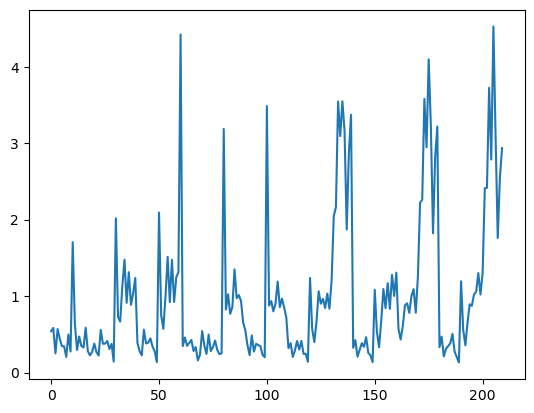

In [17]:
plt.plot(np.diag(flat_db_q)/np.diag(flat_cov_jk), '-')
#plt.yscale('log')

In [ ]:
def sshrink(cov, target, shrinkage_factor):
    """
    Compute the shrunk covariance.
    inputs:
        cov (dict): Dictionary of Jackknife covariance
        target (dict): Dictionary of target covariance
        shrinkage_factor (float): Shrinkage factor
    returns:
        shrunk_cov (dict): Dictionary of shrunk delete1 covariance
    """
    shrunk_cov = {}
    correlated_target = dices.utils.impose_correlation(cov, target)
    for key in cov:
        c = cov[key].array
        tc = correlated_target[key].array
        sc = shrinkage_factor * tc + (1 - shrinkage_factor) * c
        shrunk_cov[key] = heracles.Result(sc, axis=cov[key].axis, ell=cov[key].ell)
    return shrunk_cov

In [ ]:
sscovjk = sshrink(covjk, target_cov, 0.5)

/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/heracles/dices/utils.py:70: RuntimeWarning: invalid value encountered in sqrt
  a_std = np.sqrt(a_v[..., None, :])
/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/heracles/dices/utils.py:71: RuntimeWarning: invalid value encountered in sqrt
  b_std = np.sqrt(b_v[..., None, :])


/tmp/ipykernel_35599/2549480647.py:13: RuntimeWarning: invalid value encountered in divide
  flat_theory_corr = flat_theory_cov / np.sqrt(


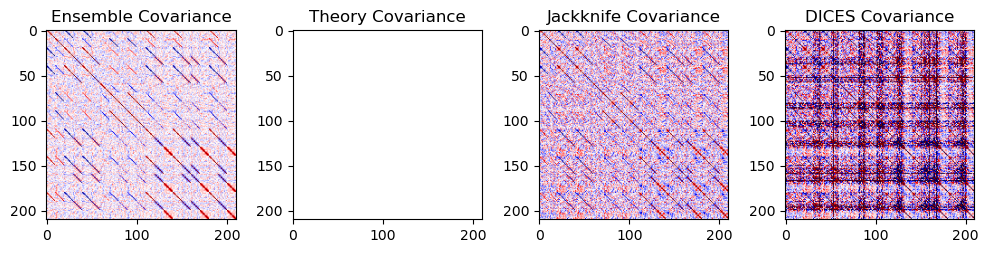

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(10, 15))

# Flattened Ensemble Covariance
flat_ens_cov = dices.flatten(ensemble_cov)
flat_ens_corr = flat_ens_cov / np.sqrt(
    np.diag(flat_ens_cov)[:, None] * np.diag(flat_ens_cov)[None, :]
)
im1 = axes[0].imshow(flat_ens_corr, cmap="seismic", vmin=-1, vmax=1)
axes[0].set_title("Ensemble Covariance")

# Flattened theory covariance
flat_theory_cov = np.zeros_like(flat_ens_cov) #dices.flatten(sb_cov)
flat_theory_corr = flat_theory_cov / np.sqrt(
    np.diag(flat_theory_cov)[:, None] * np.diag(flat_theory_cov)[None, :]
)
im2 = axes[1].imshow(flat_theory_corr, cmap="seismic", vmin=-1, vmax=1)
axes[1].set_title("Theory Covariance")

# Flattened Jackknife Covariance
fla_cov_jk = dices.flatten(covjk)
fla_corr_jk = fla_cov_jk / np.sqrt(
    np.diag(fla_cov_jk)[:, None] * np.diag(fla_cov_jk)[None, :]
)
im3 = axes[2].imshow(fla_corr_jk, cmap="seismic", vmin=-1, vmax=1)
axes[2].set_title("Jackknife Covariance")

# Flattened dices_cov
flat_dices_cov = dices.flatten(dices_cov)
flat_corr_dices = flat_dices_cov / np.sqrt(
    np.abs(np.diag(flat_dices_cov)[:, None] * np.diag(flat_dices_cov)[None, :])
)
im3 = axes[3].imshow(flat_corr_dices, cmap="seismic", vmin=-1, vmax=1)
axes[3].set_title("DICES Covariance")

plt.tight_layout()
plt.show()

/tmp/ipykernel_35599/2313579217.py:29: RuntimeWarning: invalid value encountered in sqrt
  fla_corr_jk = fla_cov_jk / np.sqrt(
/tmp/ipykernel_35599/2313579217.py:37: RuntimeWarning: invalid value encountered in sqrt
  flat_corr_dices = flat_dices_cov / np.sqrt(


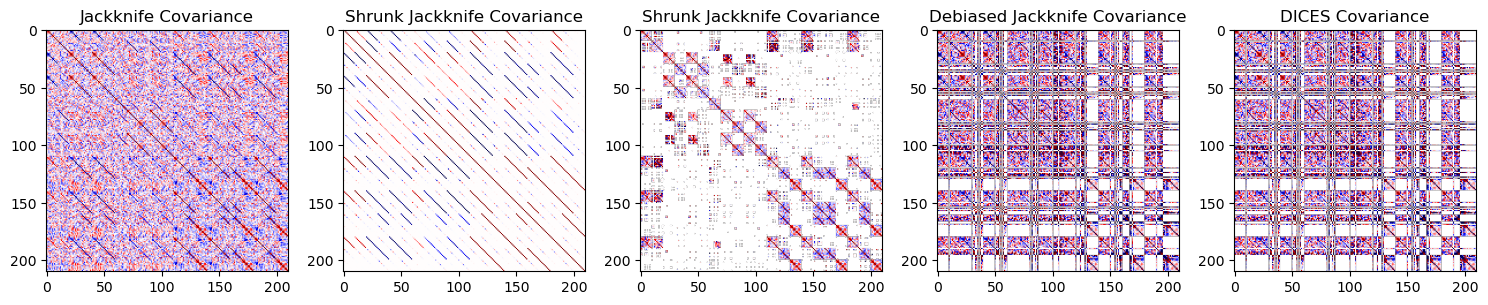

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 15))

# Flattened Ensemble Covariance
flat_ens_cov = dices.flatten(covjk)
flat_ens_corr = flat_ens_cov / np.sqrt(
    np.diag(flat_ens_cov)[:, None] * np.diag(flat_ens_cov)[None, :]
)
im1 = axes[0].imshow(flat_ens_corr, cmap="seismic", vmin=-1, vmax=1)
axes[0].set_title("Jackknife Covariance")

# target covariance
flat_theory_cov = dices.flatten(target_cov)
flat_theory_corr = flat_theory_cov / np.sqrt(
    np.diag(flat_theory_cov)[:, None] * np.diag(flat_theory_cov)[None, :]
)
im2 = axes[1].imshow(flat_theory_corr, cmap="seismic", vmin=-1, vmax=1)
axes[1].set_title("Shrunk Jackknife Covariance")

# Flattened theory covariance
flat_theory_cov = dices.flatten(sscovjk)
flat_theory_corr = flat_theory_cov / np.sqrt(
    np.diag(flat_theory_cov)[:, None] * np.diag(flat_theory_cov)[None, :]
)
im2 = axes[2].imshow(flat_theory_corr, cmap="seismic", vmin=-1, vmax=1)
axes[2].set_title("Shrunk Jackknife Covariance")

# Flattened Jackknife Covariance
fla_cov_jk = dices.flatten(db_covjk)
fla_corr_jk = fla_cov_jk / np.sqrt(
    np.diag(fla_cov_jk)[:, None] * np.diag(fla_cov_jk)[None, :]
)
im3 = axes[3].imshow(fla_corr_jk, cmap="seismic", vmin=-1, vmax=1)
axes[3].set_title("Debiased Jackknife Covariance")

# Flattened dices_cov
flat_dices_cov = dices.flatten(dices_cov)
flat_corr_dices = flat_dices_cov / np.sqrt(
    np.diag(flat_dices_cov)[:, None] * np.diag(flat_dices_cov)[None, :]
)
im3 = axes[4].imshow(flat_corr_dices, cmap="seismic", vmin=-1, vmax=1)
axes[4].set_title("DICES Covariance")

plt.tight_layout()
plt.show()

/tmp/ipykernel_35599/4264666671.py:8: RuntimeWarning: invalid value encountered in log10
  im1 = axes[0].imshow(np.log10(flat_ens_cov), cmap="seismic")
/tmp/ipykernel_35599/4264666671.py:13: RuntimeWarning: invalid value encountered in divide
  flat_theory_corr = flat_theory_cov / np.sqrt(
/tmp/ipykernel_35599/4264666671.py:24: RuntimeWarning: invalid value encountered in log10
  im3 = axes[2].imshow(np.log10(fla_cov_jk), cmap="seismic")
/tmp/ipykernel_35599/4264666671.py:29: RuntimeWarning: invalid value encountered in sqrt
  flat_dices_corr = flat_dices_cov / np.sqrt(
/tmp/ipykernel_35599/4264666671.py:32: RuntimeWarning: invalid value encountered in log10
  im3 = axes[3].imshow(np.log10(flat_dices_cov), cmap="seismic")


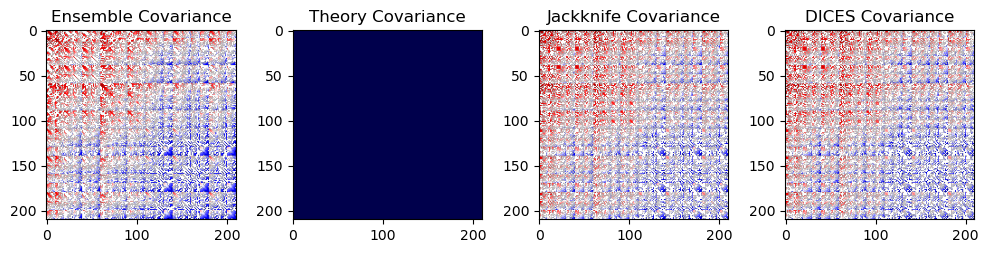

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(10, 15))

# Flattened Ensemble Covariance
flat_ens_cov = dices.flatten(ensemble_cov)
flat_ens_corr = flat_ens_cov / np.sqrt(
    np.diag(flat_ens_cov)[:, None] * np.diag(flat_ens_cov)[None, :]
)
im1 = axes[0].imshow(np.log10(flat_ens_cov), cmap="seismic")
axes[0].set_title("Ensemble Covariance")

# Flattened theory covariance
flat_theory_cov = np.zeros_like(flat_ens_cov) #dices.flatten(sb_cov)
flat_theory_corr = flat_theory_cov / np.sqrt(
    np.diag(flat_theory_cov)[:, None] * np.diag(flat_theory_cov)[None, :]
)
im2 = axes[1].imshow(flat_theory_cov, cmap="seismic")
axes[1].set_title("Theory Covariance")

# Flattened Jackknife Covariance
fla_cov_jk = dices.flatten(covjk)
fla_corr_jk = fla_cov_jk / np.sqrt(
    np.diag(fla_cov_jk)[:, None] * np.diag(fla_cov_jk)[None, :]
)
im3 = axes[2].imshow(np.log10(fla_cov_jk), cmap="seismic")
axes[2].set_title("Jackknife Covariance")

# Flattened dices_cov
flat_dices_cov = dices.flatten(dices_cov)
flat_dices_corr = flat_dices_cov / np.sqrt(
    np.diag(flat_dices_cov)[:, None] * np.diag(flat_dices_cov)[None, :]
)
im3 = axes[3].imshow(np.log10(flat_dices_cov), cmap="seismic")
axes[3].set_title("DICES Covariance")

plt.tight_layout()
plt.show()

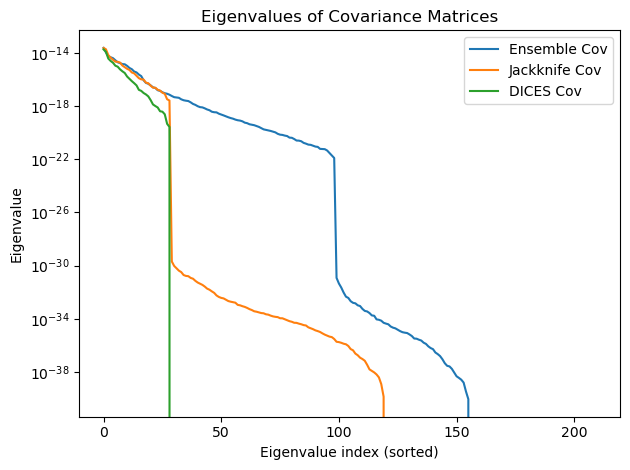

In [ ]:
# Compute eigenvalues
eig_ens = np.linalg.eigvalsh(flat_ens_cov)
eig_jk = np.linalg.eigvalsh(fla_cov_jk)
eig_dices = np.linalg.eigvalsh(flat_dices_cov)

# Sort eigenvalues for plotting
eig_ens_sorted = np.sort(eig_ens)[::-1]
eig_jk_sorted = np.sort(eig_jk)[::-1]
eig_dices_sorted = np.sort(eig_dices)[::-1]

#plt.figure(figsize=(8, 6))
plt.semilogy(eig_ens_sorted, label='Ensemble Cov')
plt.semilogy(eig_jk_sorted, label='Jackknife Cov')
plt.semilogy(eig_dices_sorted, label='DICES Cov')
plt.xlabel('Eigenvalue index (sorted)')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of Covariance Matrices')
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_35599/1569022981.py:12: RuntimeWarning: invalid value encountered in sqrt
  dcerr = np.sqrt(np.diag(dc))


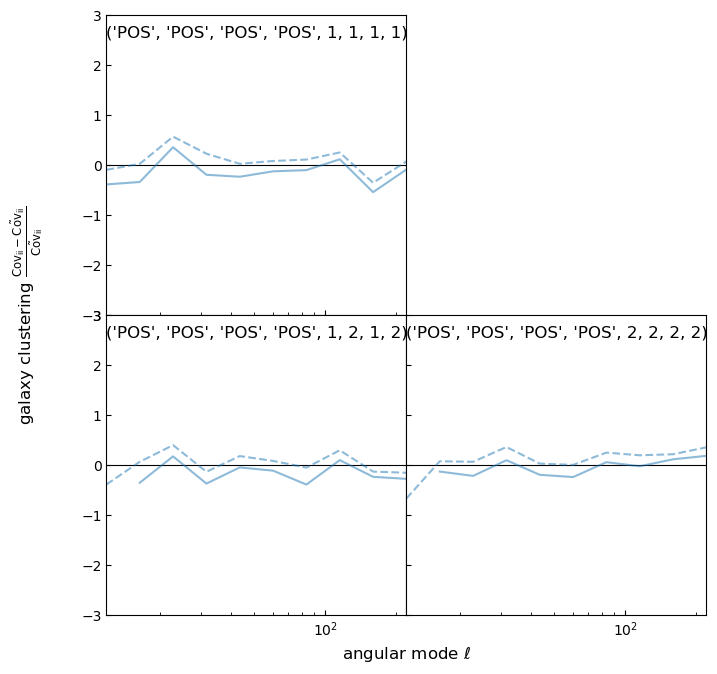

In [ ]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, nbins):
        kk = ("POS", "POS",  "POS", "POS", i, j, i, j)
        sb_kk = ("POS", "POS",  "POS", "POS", i-1, j-1, i-1, j-1)
        dc = dices_cov[kk]
        jkc = covjk[kk]
        ens_err = np.sqrt(np.diag(ensemble_cov[kk]))
        dcerr = np.sqrt(np.diag(dc))
        jkcerr = np.sqrt(np.diag(jkc))
        sberr = np.sqrt(np.diag(sb_cov[sb_kk]))/np.sqrt((np.pi))

        ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, '-', color="C0", alpha=0.5, label='DICES')
        ax[j - 1, i - 1].plot(ls, (jkcerr-ens_err)/ens_err, '--', color="C0", alpha=0.5, label='Jackknife')

        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")
        ax[j - 1, i - 1].set_title(kk, y=0.9)


ax[0, 0].set_xscale("log")
if binned:
    ax[0, 0].set_xlim(ls[0], ls[-1])
else:
    ax[0, 0].set_xlim(1, lmax+1)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-3, 3)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel(r"galaxy clustering $\frac{\rm{Cov}_{ii}-\tilde{\rm{Cov}}_{ii}}{\tilde{\rm{Cov}}_{ii}}$", x=-0.1, ha="right")

plt.show()

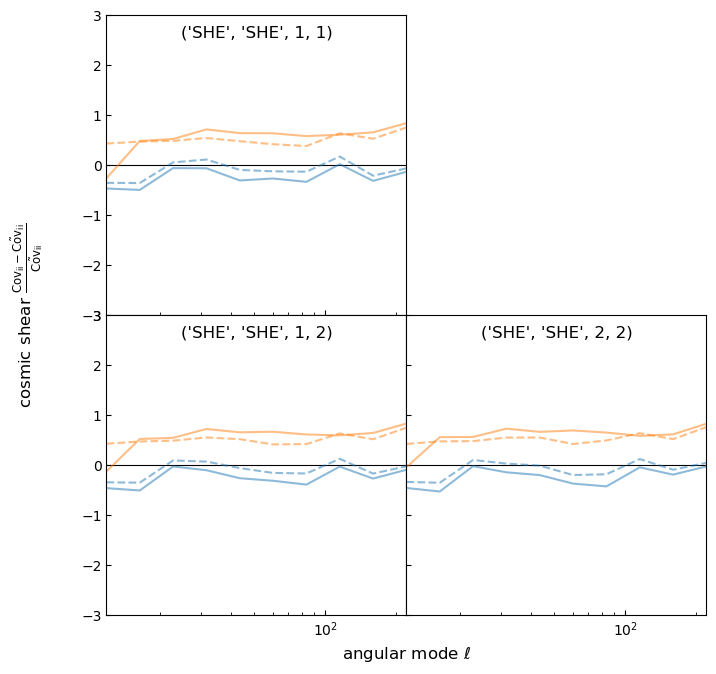

In [ ]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("SHE", "SHE", i, j)
        kk = ("SHE", "SHE",  "SHE", "SHE", i, j, i, j)
        sb_kk = ("G_E", "G_E",  "G_E", "G_E", i-1, j-1, i-1, j-1)
        _vcl = _theory_cls[key].array[0, 0, :]
        dc = dices_cov[kk][0, 0, 0, 0, :, :]
        jkc = covjk[kk][0, 0, 0, 0, :, :]
        ens_c = ensemble_cov[kk].array[0, 0, 0, 0, :, :]
        ens_err = np.sqrt(np.diag(ens_c))
        dcerr = np.sqrt(np.diag(dc))
        jkcerr = np.sqrt(np.diag(jkc))
        sberr = np.sqrt(np.diag(sb_cov[sb_kk]))/np.sqrt((np.pi))

        ax[j - 1, i - 1].plot(ls, (jkcerr-ens_err)/ens_err, '--', color="C0", alpha=0.5, label='Jackknife')
        ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, '-', color="C0", alpha=0.5, label='DICES')
        
        sb_kk = ("G_B", "G_B",  "G_B", "G_B", i-1, j-1, i-1, j-1)
        _vcl = _theory_cls[key].array[1, 1, :]
        dc = np.abs(dices_cov[kk][1, 1, 1, 1, :, :])
        jkc = np.abs(covjk[kk][1, 1, 1, 1, :, :])
        ens_c = ensemble_cov[kk].array[1, 1, 1, 1, :, :]
        ens_err = np.sqrt(np.diag(ens_c))
        jkcerr = np.sqrt(np.diag(jkc))
        dcerr = np.sqrt(np.diag(dc))

        ax[j - 1, i - 1].plot(ls, (jkcerr-ens_err)/jkcerr, '--', color="C1", alpha=0.5, label='Jackknife')
        ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/dcerr, '-', color="C1", alpha=0.5, label='DICES')

        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")
        ax[j - 1, i - 1].set_title(key, y=0.9)
ax[0, 0].set_xscale("log")
if binned:
    ax[0, 0].set_xlim(ls[0], ls[-1])
else:
    ax[0, 0].set_xlim(2, lmax+1 )
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-3, 3)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel(r"cosmic shear $\frac{\rm{Cov}_{ii}-\tilde{\rm{Cov}}_{ii}}{\tilde{\rm{Cov}}_{ii}}$", x=-0.1, ha="right")

plt.show()

/tmp/ipykernel_35599/3005490461.py:21: RuntimeWarning: invalid value encountered in sqrt
  dcerr = np.sqrt(np.diag(dc))


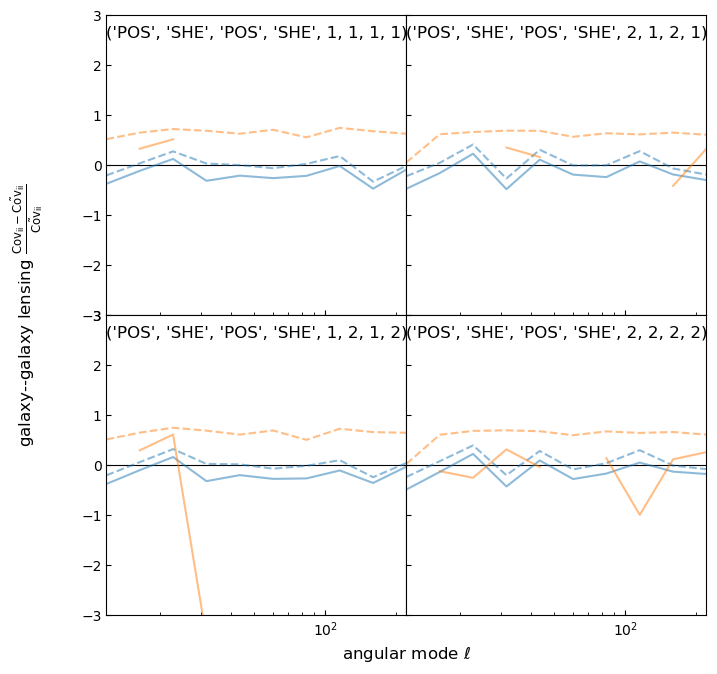

In [ ]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, nbins):
        kk = ("POS", "SHE",  "POS", "SHE", i, j, i, j)
        dc = dices_cov[kk][0, 0, :, :]
        jkc = covjk[kk][0, 0, :, :]
        ens_c = ensemble_cov[kk].array[0, 0, :, :]
        ens_err = np.sqrt(np.diag(ens_c))
        jkcerr = np.sqrt(np.diag(jkc))
        dcerr = np.sqrt(np.diag(dc))

        ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, '-', color="C0", alpha=0.5, label='DICES')
        ax[j - 1, i - 1].plot(ls, (jkcerr-ens_err)/ens_err, '--', color="C0", alpha=0.5, label='Jaxknife')

        dc = dices_cov[kk][1, 1, :, :]
        jkc = covjk[kk][1, 1, :, :]
        ens_c = ensemble_cov[kk].array[1, 1, :, :]
        ens_err = np.sqrt(np.diag(ens_c))
        jkcerr = np.sqrt(np.diag(jkc))
        dcerr = np.sqrt(np.diag(dc))

        ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/dcerr, '-', color="C1", alpha=0.5, label='DICES')
        ax[j - 1, i - 1].plot(ls, (jkcerr-ens_err)/jkcerr, '--', color="C1", alpha=0.5, label='Jaxknife')


        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")
        ax[j - 1, i - 1].set_title(kk, y=0.9)

ax[0, 0].set_xscale("log")
if binned:
    ax[0, 0].set_xlim(ls[0], ls[-1])
else:
    ax[0, 0].set_xlim(2, lmax+1)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-3, 3)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel(r"galaxy--galaxy lensing $\frac{\rm{Cov}_{ii}-\tilde{\rm{Cov}}_{ii}}{\tilde{\rm{Cov}}_{ii}}$", x=-0.1, ha="right")

plt.show()

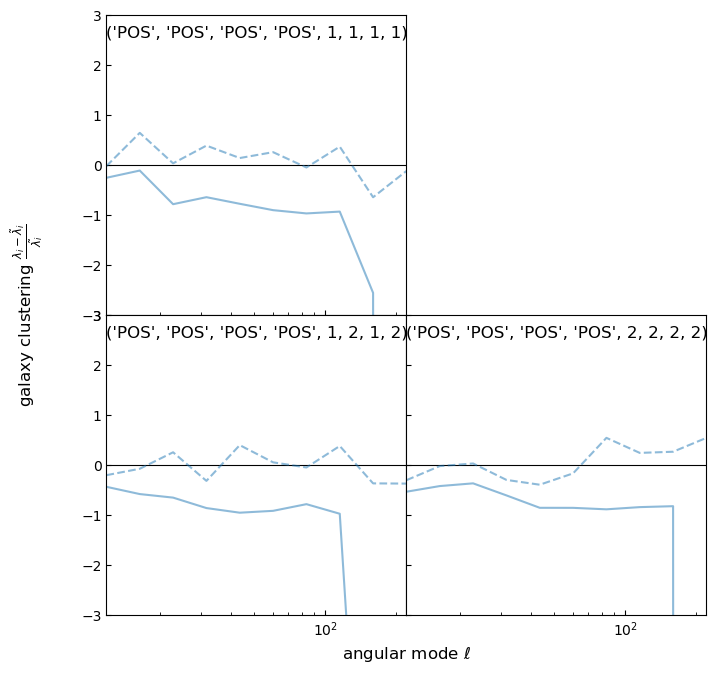

In [ ]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, nbins):
        kk = ("POS", "POS",  "POS", "POS", i, j, i, j)
        dc = dices_cov[kk]
        jkc = covjk[kk]
        ensc = ensemble_cov[kk]

        # Compute eigenvalues
        eig_ens = np.linalg.eigvalsh(ensc)
        eig_jk = np.linalg.eigvalsh(jkc)
        eig_dices = np.linalg.eigvalsh(dc)

        # Sort eigenvalues for plotting
        eig_ens_sorted = np.sort(eig_ens)[::-1]
        eig_jk_sorted = np.sort(eig_jk)[::-1]
        eig_dices_sorted = np.sort(eig_dices)[::-1]

        ax[j - 1, i - 1].plot(ls, (eig_dices_sorted-eig_ens_sorted)/eig_ens_sorted, '-', color="C0", alpha=0.5, label='DICES')
        ax[j - 1, i - 1].plot(ls, (eig_jk_sorted-eig_ens_sorted)/eig_ens_sorted, '--', color="C0", alpha=0.5, label='Jackknife')

        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")
        ax[j - 1, i - 1].set_title(kk, y=0.9)
        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)


ax[0, 0].set_xscale("log")
if binned:
    ax[0, 0].set_xlim(ls[0], ls[-1])
else:
    ax[0, 0].set_xlim(1, lmax+1)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-3, 3)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel(r"galaxy clustering $\frac{\lambda_i-\tilde{\lambda}_i}{\tilde{\lambda_i}}$", x=-0.1, ha="right")

plt.show()

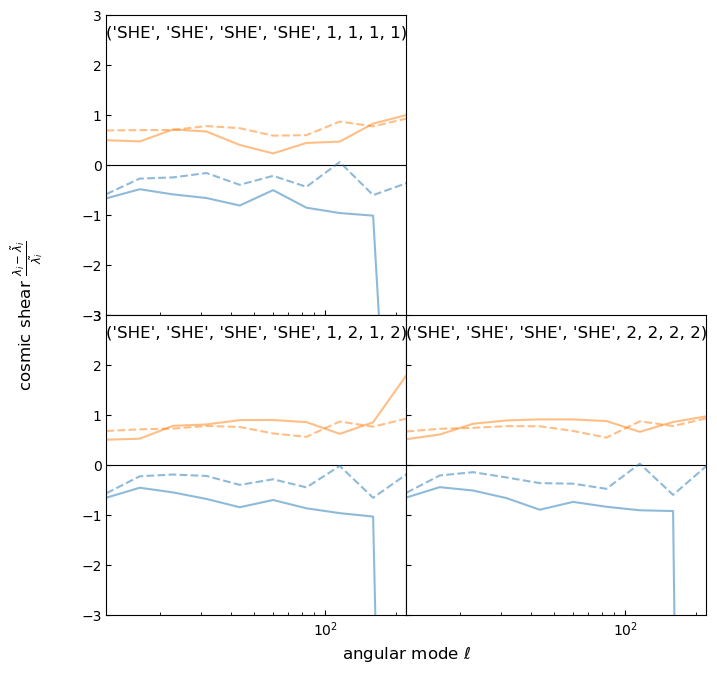

In [ ]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, nbins):
        kk = ("SHE", "SHE",  "SHE", "SHE", i, j, i, j)
        dc = dices_cov[kk][0, 0, 0, 0, :, :]
        jkc = covjk[kk][0, 0, 0, 0, :, :]
        ensc = ensemble_cov[kk].array[0, 0, 0, 0, :, :]

        # Compute eigenvalues
        eig_ens = np.linalg.eigvalsh(ensc)
        eig_jk = np.linalg.eigvalsh(jkc)
        eig_dices = np.linalg.eigvalsh(dc)

        # Sort eigenvalues for plotting
        eig_ens_sorted = np.sort(eig_ens)[::-1]
        eig_jk_sorted = np.sort(eig_jk)[::-1]
        eig_dices_sorted = np.sort(eig_dices)[::-1]

        ax[j - 1, i - 1].plot(ls, (eig_jk_sorted-eig_ens_sorted)/eig_ens_sorted, '--', color="C0", alpha=0.5, label='Jackknife')
        ax[j - 1, i - 1].plot(ls, (eig_dices_sorted-eig_ens_sorted)/eig_ens_sorted, '-', color="C0", alpha=0.5, label='DICES')
        
        sb_kk = ("G_B", "G_B",  "G_B", "G_B", i-1, j-1, i-1, j-1)
        dc = np.abs(dices_cov[kk][1, 1, 1, 1, :, :])
        jkc = np.abs(covjk[kk][1, 1, 1, 1, :, :])
        ensc = ensemble_cov[kk].array[1, 1, 1, 1, :, :]
        
        # Compute eigenvalues
        eig_ens = np.linalg.eigvalsh(ensc)
        eig_jk = np.linalg.eigvalsh(jkc)
        eig_dices = np.linalg.eigvalsh(dc)

        # Sort eigenvalues for plotting
        eig_ens_sorted = np.sort(eig_ens)[::-1]
        eig_jk_sorted = np.sort(eig_jk)[::-1]
        eig_dices_sorted = np.sort(eig_dices)[::-1]

        ax[j - 1, i - 1].plot(ls, (eig_jk_sorted-eig_ens_sorted)/eig_jk_sorted, '--', color="C1", alpha=0.5, label='Jackknife')
        ax[j - 1, i - 1].plot(ls, (eig_dices_sorted-eig_ens_sorted)/eig_dices_sorted, '-', color="C1", alpha=0.5, label='DICES')

        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")
        ax[j - 1, i - 1].set_title(kk, y=0.9)
ax[0, 0].set_xscale("log")
if binned:
    ax[0, 0].set_xlim(ls[0], ls[-1])
else:
    ax[0, 0].set_xlim(2, lmax+1 )
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-3, 3)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel(r"cosmic shear $\frac{\lambda_i-\tilde{\lambda}_i}{\tilde{\lambda_i}}$", x=-0.1, ha="right")

plt.show()

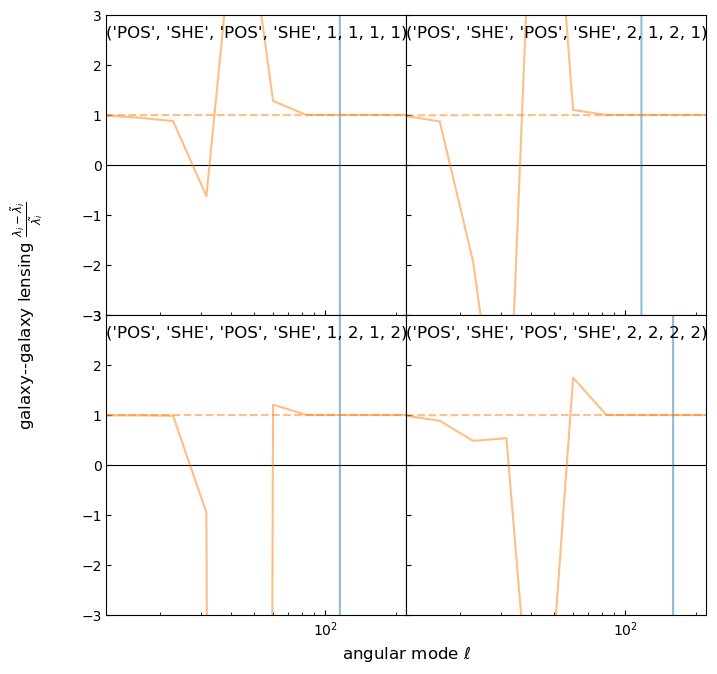

In [ ]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, nbins):
        kk = ("POS", "SHE",  "POS", "SHE", i, j, i, j)
        dc = dices_cov[kk][0, 0, :, :]
        jkc = covjk[kk][0, 0, :, :]
        ens_c = ensemble_cov[kk].array[0, 0, :, :]

        # Compute eigenvalues
        eig_ens = np.linalg.eigvalsh(ensc)
        eig_jk = np.linalg.eigvalsh(jkc)
        eig_dices = np.linalg.eigvalsh(dc)

        # Sort eigenvalues for plotting
        eig_ens_sorted = np.sort(eig_ens)[::-1]
        eig_jk_sorted = np.sort(eig_jk)[::-1]
        eig_dices_sorted = np.sort(eig_dices)[::-1]

        ax[j - 1, i - 1].plot(ls, (eig_dices_sorted-eig_ens_sorted)/eig_ens_sorted, '-', color="C0", alpha=0.5, label='DICES')
        ax[j - 1, i - 1].plot(ls, (eig_jk_sorted-eig_ens_sorted)/eig_ens_sorted, '--', color="C0", alpha=0.5, label='Jaxknife')

        dc = dices_cov[kk][1, 1, :, :]
        jkc = covjk[kk][1, 1, :, :]
        ens_c = ensemble_cov[kk].array[1, 1, :, :]
        
        # Compute eigenvalues
        eig_ens = np.linalg.eigvalsh(ensc)
        eig_jk = np.linalg.eigvalsh(jkc)
        eig_dices = np.linalg.eigvalsh(dc)

        # Sort eigenvalues for plotting
        eig_ens_sorted = np.sort(eig_ens)[::-1]
        eig_jk_sorted = np.sort(eig_jk)[::-1]
        eig_dices_sorted = np.sort(eig_dices)[::-1]

        ax[j - 1, i - 1].plot(ls, (eig_dices_sorted-eig_ens_sorted)/eig_dices_sorted, '-', color="C1", alpha=0.5, label='DICES')
        ax[j - 1, i - 1].plot(ls, (eig_jk_sorted-eig_ens_sorted)/eig_jk_sorted, '--', color="C1", alpha=0.5, label='Jaxknife')


        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")
        ax[j - 1, i - 1].set_title(kk, y=0.9)

ax[0, 0].set_xscale("log")
if binned:
    ax[0, 0].set_xlim(ls[0], ls[-1])
else:
    ax[0, 0].set_xlim(2, lmax+1)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-3, 3)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel(r"galaxy--galaxy lensing $\frac{\lambda_i-\tilde{\lambda}_i}{\tilde{\lambda_i}}$", x=-0.1, ha="right")

plt.show()